# Model-1 Fine-tune - Gab-Reddit

The aim of this notebook is to demonstrate the efficacy of the model in relation to the Gab and Reddit dataset while an identical approach from Model-1 is taken. Model-1, here under the monomer of GRmodel, is fine-tuned using the Gab_reddit dataset from Mody et al(2023) and Qian et al(2019). Finally, the test datasets are evaluated against each other with metrics such as accuracy, precision and F1 followed by the ROC-AUC comparison curve.

## Part 1: Data Preparation
- Loading data to fine-tune using Huggingface's load_dataset module
- Split the dataset into train and test
- Clean the dataset for any missing values

## Part 2: Load tokenizer
- Load the tokenizer for the chosen model
- Tokenize the text in 'Content' of the dataset
- Use data collator from Huggingface to batch texts of similar lengths

## Part 3: Model class definition

- Definition of the model with the pre-trained layer, Bidirectional LSTM and CNN layer to generate the necessary classified output
- Save the model in the cuda device

## Part 3: Training
- Creation of dataloaders for train and test
- Instantiate the AdamW optimiser for 5 epochs
- Setting a learning rate of 2e-5
- Setting of the metrics required to evaluate model performance
- Training the model on the train dataset
- Evaluation using test dataset

## Part 4: Testing on Gab and Reddit

- Load Gab and reddit test datasets
- Testing the model on Gab and Reddit
- plotting ROC-AUC for Gab
- plotting ROC-AUC for Reddit
- plotting a comparison ROC-AUC





# Data preparation

In [ ]:
#mount google drive to upload files
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#install transformers module
pip install datasets transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.0 MB/s eta 0:00:00


In [ ]:
#import necessary modules
from datasets import load_dataset,Dataset,DatasetDict
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
import pandas as pd

In [ ]:
#load training data for gab_reddit
data=load_dataset("csv",data_files="/content/drive/My Drive/gabb_reddit_train.csv")
data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Content', 'Label'],
        num_rows: 35635
    })
})

In [ ]:
#split the dataset into train and validation
data.set_format('pandas')
data=data['train'][:]
data=Dataset.from_pandas(data)
train_testvalid = data.train_test_split(test_size=0.2,seed=15)


In [ ]:
train_testvalid

DatasetDict({
    train: Dataset({
        features: ['Content', 'Label'],
        num_rows: 28508
    })
    test: Dataset({
        features: ['Content', 'Label'],
        num_rows: 7127
    })
})

In [ ]:
data = DatasetDict({
    'train': train_testvalid['train'],
    'valid': train_testvalid['test']})

data

DatasetDict({
    train: Dataset({
        features: ['Content', 'Label'],
        num_rows: 28508
    })
    valid: Dataset({
        features: ['Content', 'Label'],
        num_rows: 7127
    })
})

In [ ]:
#delete null rows from the dataset
def delete_null_rows(dataset_dict):
    for key, dataset in dataset_dict.items():
        null_indices = [idx for idx, row in enumerate(dataset) if any(value is None for value in row.values())]
        dataset = dataset.select([i for i in range(len(dataset)) if i not in null_indices])
        dataset_dict[key] = dataset



delete_null_rows(data)

# Load Tokenizer

In [ ]:
#upload the tokenizer from the checkpoint in Huggingface
checkpoint = "cardiffnlp/twitter-roberta-base-hate-latest"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
#set maximum token length for the model intake
tokenizer.model_max_len=512

In [ ]:
#map the tokenizer to the text in each sample in batches of the dataset
def tokenize(batch):
  return tokenizer(batch["Content"], truncation=True,max_length=100)

tokenized_dataset = data.map(tokenize, batched=True)
tokenized_dataset

Map:   0%|          | 0/28276 [00:00<?, ? examples/s]

Map:   0%|          | 0/7063 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Content', 'Label', 'input_ids', 'attention_mask'],
        num_rows: 28276
    })
    valid: Dataset({
        features: ['Content', 'Label', 'input_ids', 'attention_mask'],
        num_rows: 7063
    })
})

In [ ]:
#set datacollator for the tokenizer to measure the length of the tokens and batch accordingly
tokenized_dataset.set_format("torch",columns=["input_ids", "attention_mask", "Label"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Model definition

In [ ]:
#create a class for the fine-tuning of the pre-trained model used

class GRmodel(nn.Module):
  def __init__(self, checkpoint, num_labels):
    super(GRmodel, self).__init__()
    self.num_labels = num_labels

    # Load Model with given checkpoint and extract its body
    self.model = model = AutoModel.from_pretrained(checkpoint, config=AutoConfig.from_pretrained(checkpoint, output_attentions=True, output_hidden_states=True))
    self.dropout = nn.Dropout(0.1)

    # Add BiLSTM layers
    hidden_size = 768
    num_layers = 2
    self.bilstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)

    # Add CNN layer
    kernel_size = 3
    self.cnn = nn.Conv1d(hidden_size * 2, hidden_size, kernel_size)

    self.classifier = nn.Linear(hidden_size, num_labels)  # load and initialize weights

  def forward(self, input_ids=None, attention_mask=None, Label=None):
    # Extract outputs from the body
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

    # Add custom layers
    sequence_output = self.dropout(outputs[0])  # outputs[0]=last hidden state

    # Apply BiLSTM
    lstm_output, _ = self.bilstm(sequence_output)

    # Apply CNN
    lstm_output = lstm_output.permute(0, 2, 1)  # Reshape for Conv1d
    cnn_output = self.cnn(lstm_output)
    cnn_output = cnn_output.permute(0, 2, 1)  # Reshape back to original

    logits = self.classifier(cnn_output[:, -1, :])  # calculate losses

    loss = None
    if Label is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), Label.view(-1))

    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #saves the model in cuda if available
model=GRmodel(checkpoint=checkpoint,num_labels=2).to(device) #creates a model with the checkpoint from Huggingface

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate-latest and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training

In [ ]:
#loading the data into tensor format for the model to process
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_dataset["train"], shuffle=True, batch_size=16, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_dataset["valid"], batch_size=16, collate_fn=data_collator
)

In [ ]:
#instantiating the necessary model parameters within the optimiser
from transformers import AdamW,get_scheduler

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

8840


In [ ]:
#initialise metrics for the evaluation
from datasets import load_metric
metric1 = load_metric("f1")
metric2 = load_metric("accuracy")
metric3 = load_metric("precision")

<ipython-input-18-b50ad69f36bb>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric1 = load_metric("f1")


In [ ]:
#training
from tqdm.auto import tqdm

progress_bar_train = tqdm(range(num_training_steps))
progress_bar_eval = tqdm(range(num_epochs * len(eval_dataloader)))


for epoch in range(num_epochs):
  model.train()
  for batch in train_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()

      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()
      progress_bar_train.update(1)

  model.eval()
  for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric1.add_batch(predictions=predictions, references=batch["Label"])
    metric2.add_batch(predictions=predictions, references=batch["Label"])
    metric3.add_batch(predictions=predictions, references=batch["Label"])

    progress_bar_eval.update(1)

  print(metric1.compute())
  print(metric2.compute())
  print(metric3.compute())








  0%|          | 0/8840 [00:00<?, ?it/s]

  0%|          | 0/2210 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'f1': 0.921378387420542}
{'accuracy': 0.9334560385105479}
{'precision': 0.9418604651162791}
{'f1': 0.921817574340127}
{'accuracy': 0.93373920430412}
{'precision': 0.9409959072305594}
{'f1': 0.9152933421226105}
{'accuracy': 0.9272263910519609}
{'precision': 0.9213669542136695}
{'f1': 0.9144736842105263}
{'accuracy': 0.9263768936712445}
{'precision': 0.9187045604758758}
{'f1': 0.9098360655737705}
{'accuracy': 0.9221294067676624}
{'precision': 0.9110308601444518}


In [ ]:
import os

In [ ]:
save_directory ="/content/drive/My Drive"

In [ ]:
torch.save(model.state_dict(),os.path.join(save_directory, "GR_bert+lstm+cnn.pt")) #model path to load the model using torch.load

# Testing

## GAB

In [ ]:
#Load the pre-processed data
gab = load_dataset('csv',data_files='gab_again2.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
gab.set_format('pandas')
gab=gab['train'][:]
gab=Dataset.from_pandas(gab)
gab = DatasetDict({'test':gab})
gab

DatasetDict({
    test: Dataset({
        features: ['Unnamed: 0', 'Content', 'Label'],
        num_rows: 3007
    })
})

In [ ]:
#remove the extra unnamed column
gab = gab.remove_columns('Unnamed: 0')
def tokenize(batch):
    return tokenizer(batch["Content"], truncation=True, max_length=max_length)


In [ ]:
#set the maximum length of the tokens to pad accordingly
max_length=75
gab_t = gab.map(tokenize, batched=True)

Map:   0%|          | 0/3007 [00:00<?, ? examples/s]

In [ ]:
#max_length=75
gab_t.set_format("torch",columns=["input_ids", "attention_mask", "Label"])
dataloader = DataLoader(
    gab_t["test"], batch_size=8, collate_fn=data_collator
)

model.eval()


progress_bar_eval = tqdm(range(1 * len(dataloader)))


for batch in dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions_g= torch.argmax(logits, dim=-1)
    metric1.add_batch(predictions=predictions_g, references=batch["Label"])
    metric2.add_batch(predictions=predictions_g, references=batch["Label"])
    metric3.add_batch(predictions=predictions_g, references=batch["Label"])
    progress_bar_eval.update(1)

print(metric1.compute())
print(metric2.compute())
print(metric3.compute())

  0%|          | 0/376 [00:00<?, ?it/s]

{'f1': 0.37681159420289856}
{'accuracy': 0.9142001995344197}
{'precision': 0.39195979899497485}


# Reddit

In [ ]:
reddit= load_dataset('csv',data_files='cleaned_reddit4.csv')


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
reddit.set_format('pandas')
reddit=reddit['train'][:]
reddit=Dataset.from_pandas(reddit)
reddit = DatasetDict({'test':reddit})
reddit = reddit.remove_columns('Unnamed: 0')

In [ ]:
max_length=30
tokenized_reddit = reddit.map(tokenize, batched=True)
tokenized_reddit

Map:   0%|          | 0/2117 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['Content', 'Label', 'input_ids', 'attention_mask'],
        num_rows: 2117
    })
})

In [ ]:
tokenized_reddit.set_format("torch",columns=["input_ids", "attention_mask", "Label"])
reddit_dataloader = DataLoader(
    tokenized_reddit["test"], batch_size=16, collate_fn=data_collator
)

In [ ]:
model.eval()


progress_bar_eval = tqdm(range(1 * len(reddit_dataloader)))


for batch in reddit_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions_reddit = torch.argmax(logits, dim=-1)
    metric1.add_batch(predictions=predictions_reddit, references=batch["Label"])
    metric2.add_batch(predictions=predictions_reddit, references=batch["Label"])
    metric3.add_batch(predictions=predictions_reddit, references=batch["Label"])
    progress_bar_eval.update(1)

print(metric1.compute())
print(metric2.compute())
print(metric3.compute())

  0%|          | 0/133 [00:00<?, ?it/s]

{'f1': 0.38795986622073575}
{'accuracy': 0.7406707605101559}
{'precision': 0.38839285714285715}


# ROC-AUC Evaluation curve

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
gab_predictions2=[]
gab_true_labels2=[]

model.eval()
with torch.no_grad():
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        logits = outputs.logits
        predictions_g = torch.argmax(logits, dim=-1)
        true_labels = batch["Label"]

        gab_predictions2.extend(predictions_g.cpu().numpy())
        gab_true_labels2.extend(true_labels.cpu().numpy())
        #progress_bar_eval = tqdm(range(1 * len(twitter_dataloader)))


# Convert the lists to NumPy arrays
gab_predictions2 = np.array(gab_predictions2)
gab_true_labels2 = np.array(gab_true_labels2)

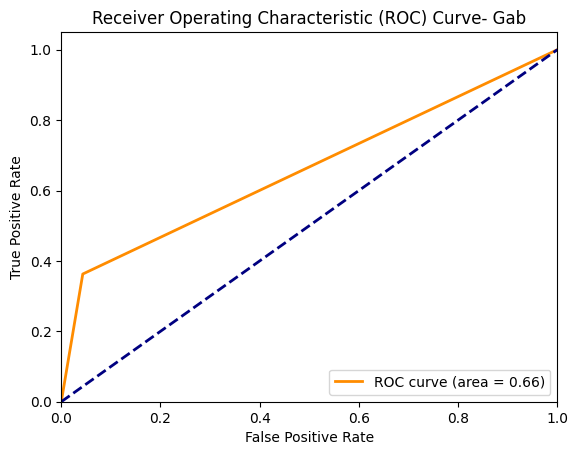

In [ ]:
fpr_g, tpr_g, thresholds = roc_curve(gab_true_labels2, gab_predictions2)
roc_auc_gab = roc_auc_score(gab_true_labels2, gab_predictions2)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_g, tpr_g, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_gab)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- Gab')
plt.legend(loc='lower right')
plt.show()

In [ ]:
reddit_predictions=[]
reddit_true_labels=[]

model.eval()
with torch.no_grad():
    for batch in reddit_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        logits = outputs.logits
        predictions_reddit = torch.argmax(logits, dim=-1)
        true_labels = batch["Label"]

        reddit_predictions.extend(predictions_reddit.cpu().numpy())
        reddit_true_labels.extend(true_labels.cpu().numpy())
        #progress_bar_eval = tqdm(range(1 * len(twitter_dataloader)))


# Convert the lists to NumPy arrays
reddit_predictions = np.array(reddit_predictions)
reddit_true_labels = np.array(reddit_true_labels)

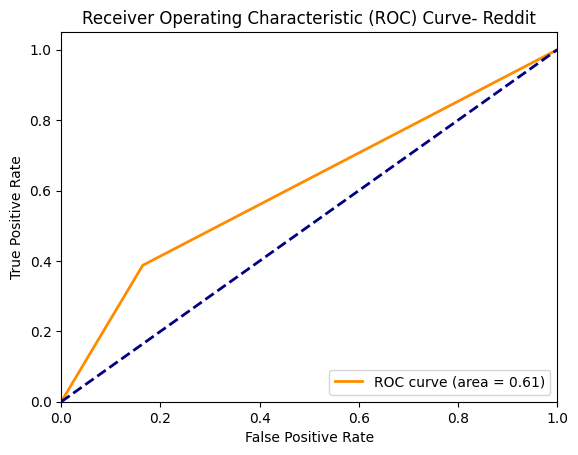

In [ ]:
fpr3, tpr3, thresholds = roc_curve(reddit_true_labels, reddit_predictions)
roc_auc_reddit = roc_auc_score(reddit_true_labels, reddit_predictions)

# Plot the ROC curve
plt.figure()
plt.plot(fpr3, tpr3, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_reddit)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- Reddit')
plt.legend(loc='lower right')
plt.show()

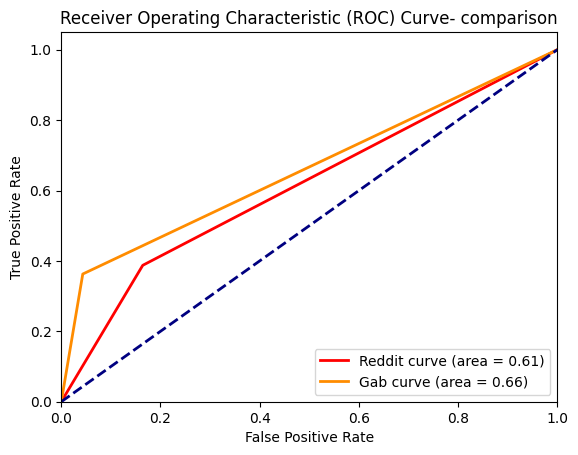

In [ ]:
plt.figure()
plt.plot(fpr3, tpr3, color='red', lw=2, label='Reddit curve (area = %0.2f)' % roc_auc_reddit)
plt.plot(fpr_g, tpr_g, color='darkorange', lw=2, label='Gab curve (area = %0.2f)' % roc_auc_gab)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- comparison')
plt.legend(loc='lower right')
plt.show()